# Research Goal: Investigating the historical daily prices and volumes of all U.S. stocks and ETFs.

In [9]:
!pip install pmdarima

In [17]:
#Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

# Regular libraries for data manipulation
import pprint
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# Visualization
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Statistical tools for time series analysis
from scipy import signal
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.api as smapi

from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

from pylab import rcParams

In [18]:
data = pd.read_csv(
    '../input/cac40-stocks-dataset/preprocessed_CAC40.csv', 
    usecols = ['Name','Date','Open','Closing_Price','Daily_High','Daily_Low','Volume']
)

In [19]:
# Filtering the dataframe to focus on Air Liquide stocks
air_liquide = data[data['Name'] == 'Air Liquide'].copy()

# Converting the 'Date' column to a datetime object
air_liquide['Date'] = pd.to_datetime(air_liquide['Date'])

# Extracting year and month from the 'Date' column and adding them as separate columns
air_liquide['Year'] = air_liquide['Date'].dt.year
air_liquide['Month'] = air_liquide['Date'].dt.month

# Printing the shape of the 'air_liquide' dataframe
print(f'air_liquide shape: {air_liquide.shape[0]} rows, {air_liquide.shape[1]} columns')

air_liquide shape: 2600 rows, 9 columns


In [20]:
air_liquide.head()

,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume,Year,Month
2599,Air Liquide,2020-04-02,116.00,112.95,116.00,110.00,331,2020,4
2600,Air Liquide,2020-04-01,115.95,114.05,115.95,112.30,480,2020,4
2601,Air Liquide,2020-03-31,113.90,114.60,115.35,112.95,784,2020,3
2602,Air Liquide,2020-03-30,110.25,112.15,112.70,106.90,485,2020,3
2603,Air Liquide,2020-03-27,110.20,107.00,110.20,105.80,525,2020,3


# EDA

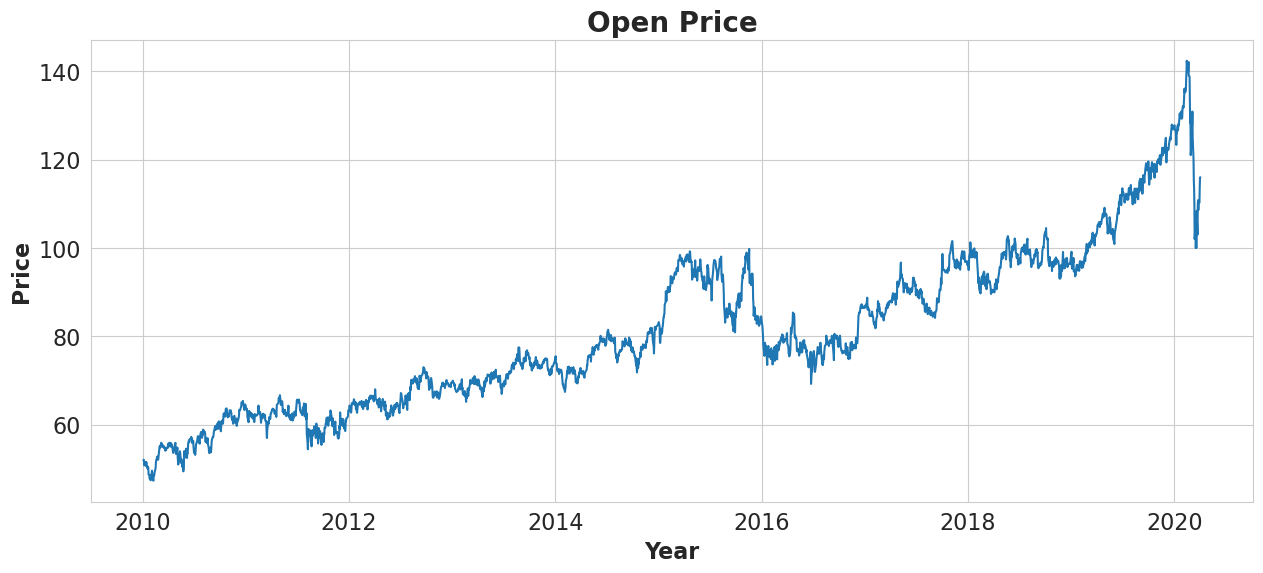

In [21]:
fig, ax = plt.subplots(figsize = (15, 6))
sns.lineplot(x = air_liquide['Date'], y = air_liquide['Open'] )

ax.set_title("Open Price", fontsize = 20, loc = "center", fontdict = dict(weight = "bold"))
ax.set_xlabel("Year", fontsize = 16, fontdict = dict(weight = "bold"))
ax.set_ylabel("Price", fontsize = 16, fontdict = dict(weight = "bold"))
plt.tick_params(axis = "y", which = "major", labelsize = 16)
plt.tick_params(axis = "x", which = "major", labelsize = 16)

In [22]:
air_liquide.isnull().sum()

Name               0
Date               0
Open               1
Closing_Price      0
Daily_High         0
Daily_Low          0
Volume           134
Year               0
Month              0
dtype: int64

<Axes: >

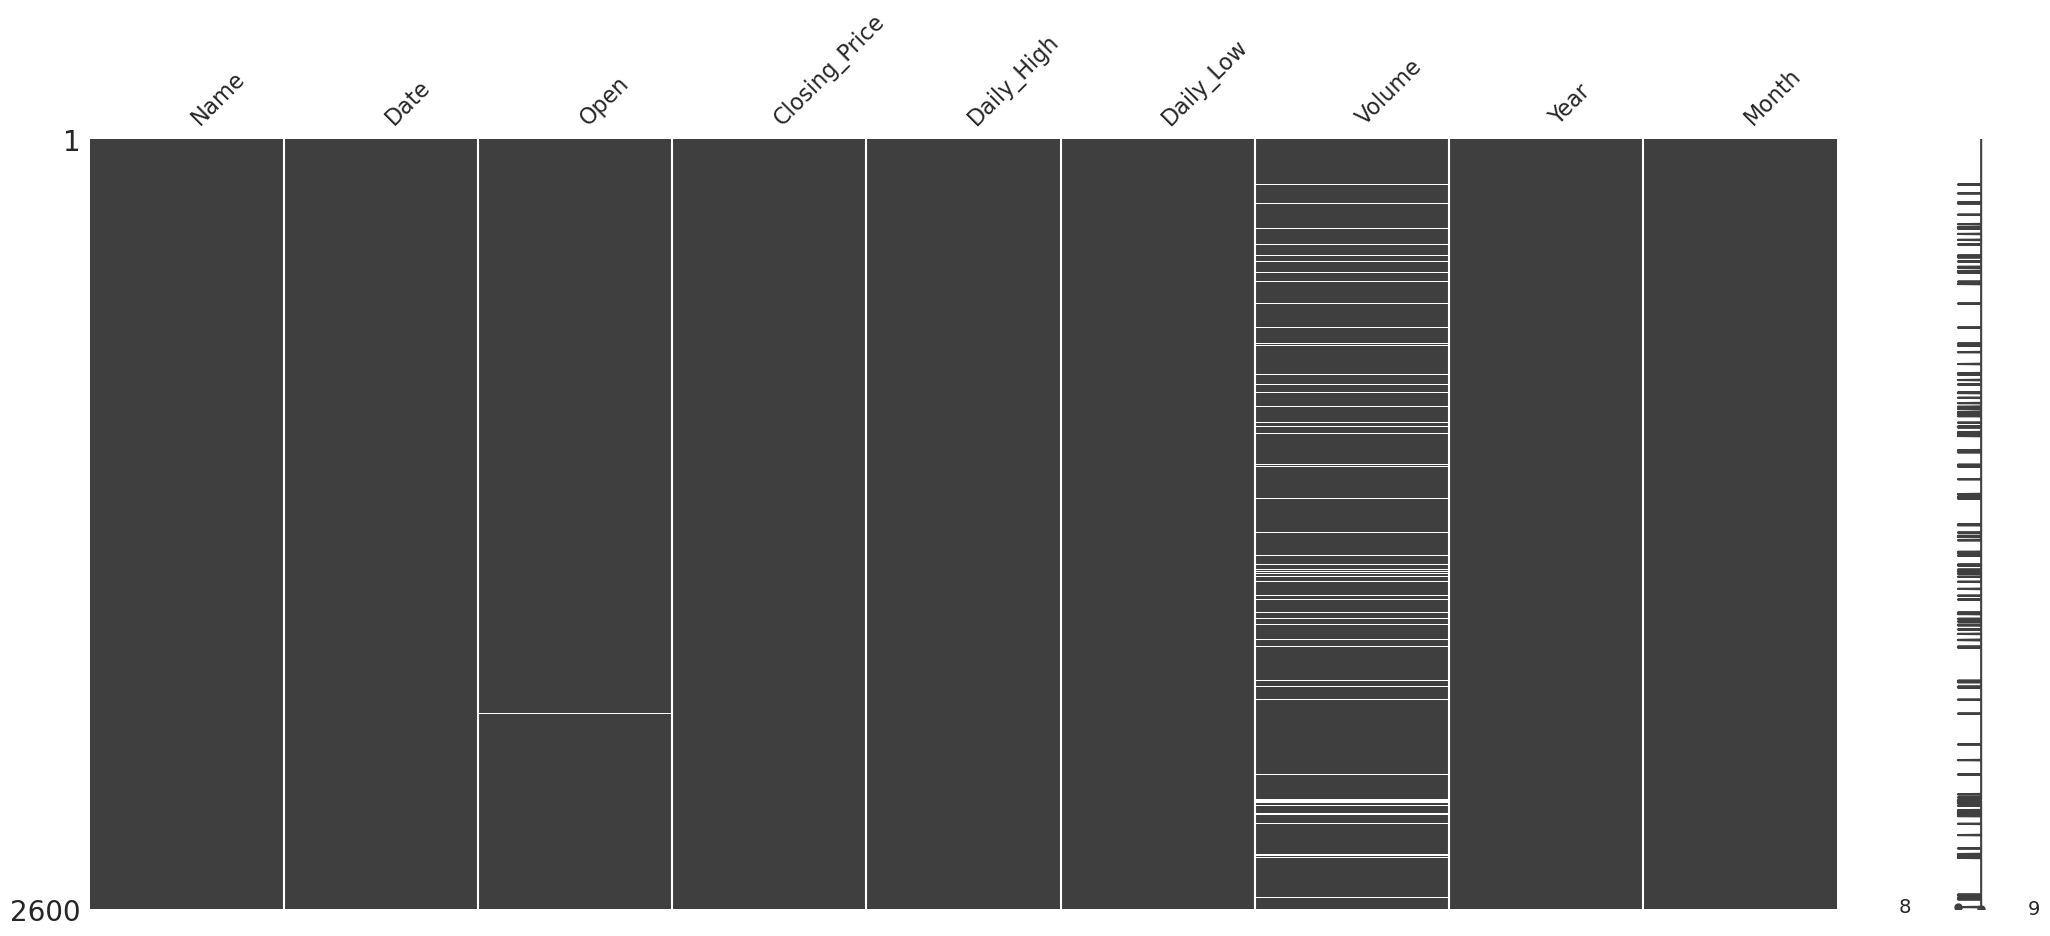

In [23]:
msno.matrix(air_liquide)

In [24]:
index_open_missing = air_liquide[pd.isnull(air_liquide["Open"])].index
print("Index of the missing value in the Open column: ", list(index_open_missing)[0])

Index of the missing value in the Open column:  4538


In [25]:
# Replace the missing value in the 'Open' column with the value from the previous day (backward fill)
air_liquide['Open'] = air_liquide['Open'].fillna(method='bfill')

# Calculate and print the percentage of missing values in the 'Volume' column
print(f"Percentage of missing values in Volume: {round(sum(pd.isnull(air_liquide['Volume']))/air_liquide.shape[0],2)}\n")
print(air_liquide[air_liquide['Volume']==0])

Percentage of missing values in Volume: 0.05

Empty DataFrame
Columns: [Name, Date, Open, Closing_Price, Daily_High, Daily_Low, Volume, Year, Month]
Index: []


In [26]:
imputer = SimpleImputer(strategy = "constant", fill_value = 0)
air_liquide_plus = imputer.fit_transform(air_liquide)
imputed_air_liquide = pd.DataFrame(air_liquide_plus)
imputed_air_liquide.columns = air_liquide.columns

In [27]:
imputed_air_liquide["Volume"] = imputed_air_liquide["Volume"].apply(lambda x: str(x))
imputed_air_liquide["Volume"] = pd.to_numeric(imputed_air_liquide["Volume"].apply(lambda x: x.replace(',', '', 1)))

imputed_air_liquide["Open"] = pd.to_numeric(imputed_air_liquide["Open"])
imputed_air_liquide["Closing_Price"] = pd.to_numeric(imputed_air_liquide["Closing_Price"])
imputed_air_liquide["Daily_High"] = pd.to_numeric(imputed_air_liquide["Daily_High"])
imputed_air_liquide["Daily_Low"] = pd.to_numeric(imputed_air_liquide["Daily_Low"])

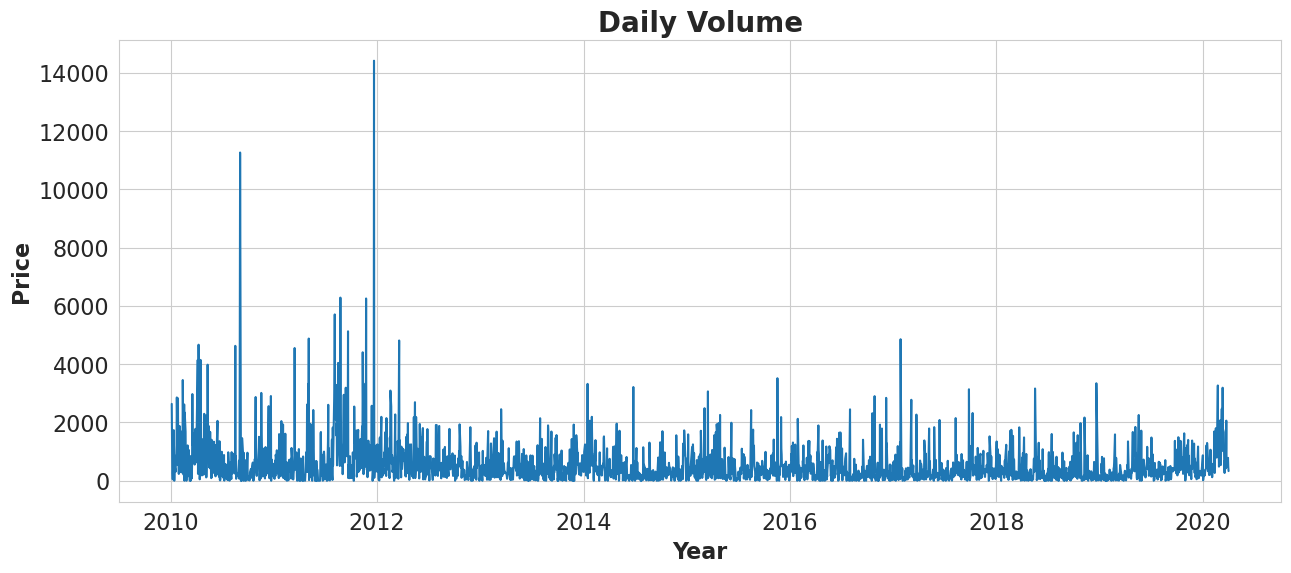

In [28]:
# Plot Daily Volume Lineplot
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = imputed_air_liquide['Date'], y = imputed_air_liquide['Volume'] )

# Formatting
ax.set_title('Daily Volume', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

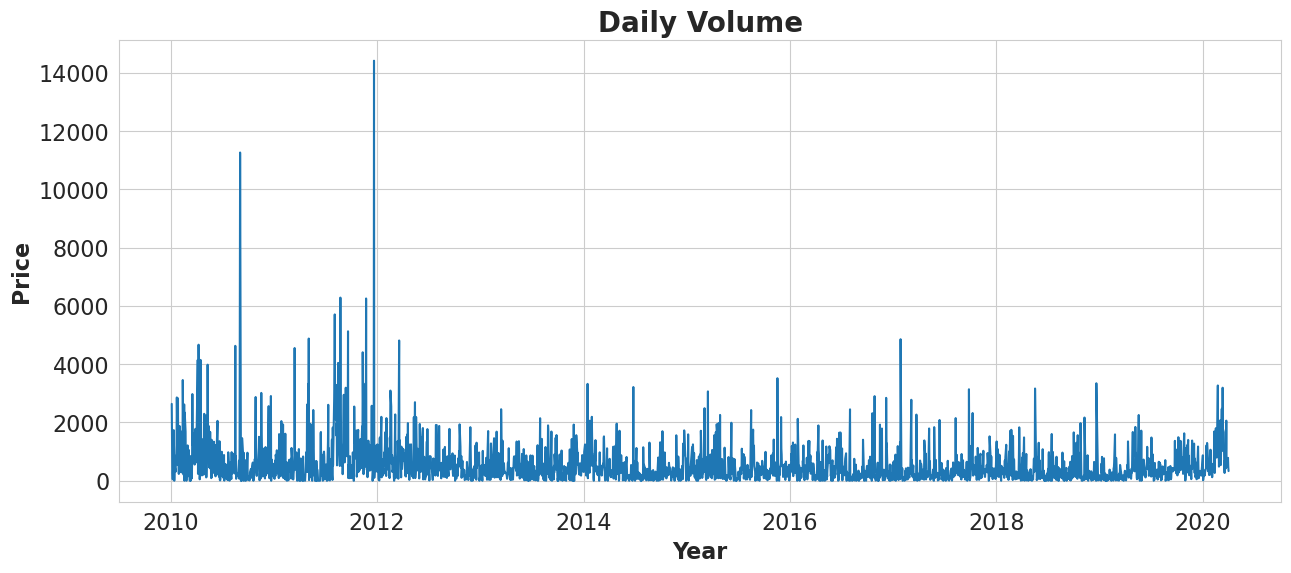

In [29]:
fig, ax = plt.subplots(figsize = (15, 6))
sns.lineplot(x = imputed_air_liquide["Date"], y = imputed_air_liquide["Volume"])
ax.set_title("Daily Volume", fontsize = 20, loc = "center", fontdict = dict(weight = "bold"))
ax.set_xlabel("Year", fontsize = 16, fontdict =dict(weight = "bold"))
ax.set_ylabel("Price", fontsize = 16, fontdict = dict(weight = "bold"))
plt.tick_params(axis = "y", which = "major", labelsize = 16)
plt.tick_params(axis = "x", which = "major", labelsize = 16)

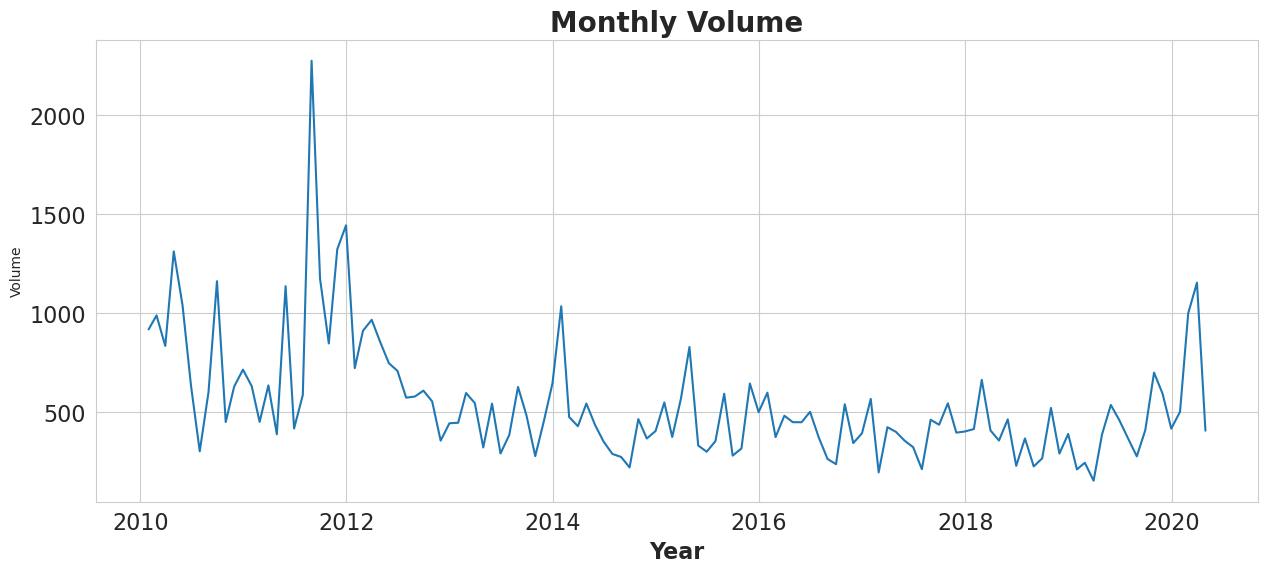

In [30]:
# Create a copy of the 'Date' and 'Volume' columns
y = imputed_air_liquide[['Date','Volume']].copy()

# Set the index to 'Date' and convert it to datetime format
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)

# Resample the time series to monthly and compute the mean of each month
y = y.resample('1M').mean()

# Add the 'Date' column back to the DataFrame
y['Date'] = y.index

# Plot the monthly volume time series
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = y['Date'], y = y['Volume'] )

# Set the title and axes labels
ax.set_title('Monthly Volume', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

In [31]:
y = imputed_air_liquide[[
    "Date", "Volume"
]].copy()

y.set_index("Date", inplace = True)
y.index = pd.to_datetime(y.index)
y = y.resample("1M").mean()
y["Date"] = y.index

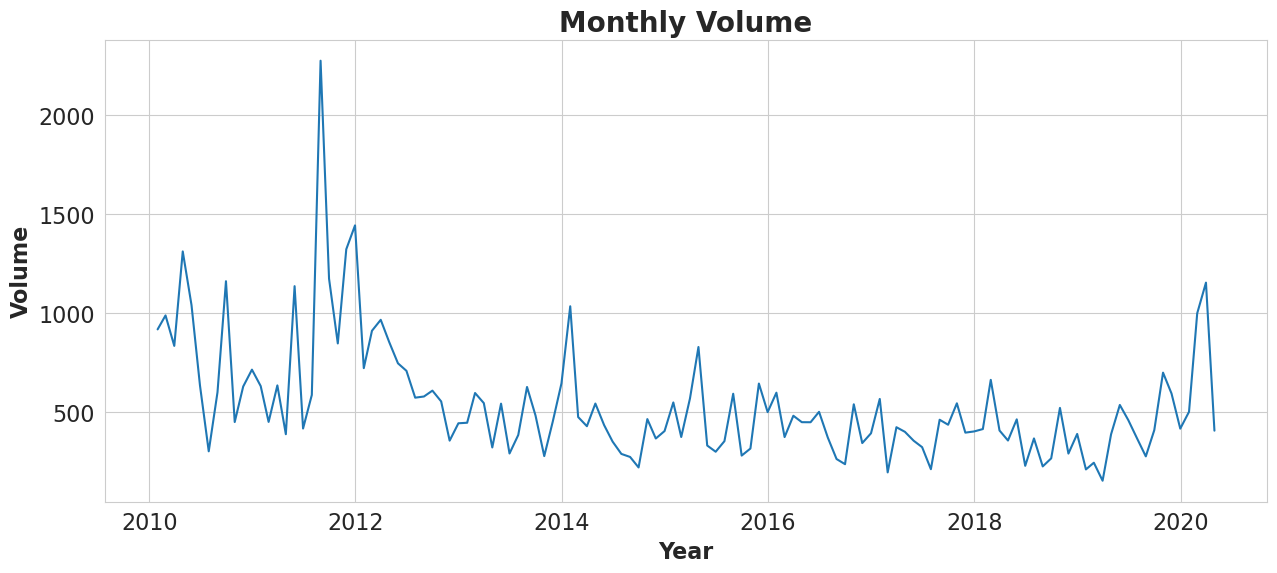

In [32]:
fig, ax = plt.subplots(figsize = (15, 6))
sns.lineplot(x = y["Date"], y = y["Volume"])
ax.set_title("Monthly Volume", fontsize = 20, loc = "center", fontdict = dict(weight = "bold"))
ax.set_xlabel("Year", fontsize = 16, fontdict = dict(weight = "bold"))
ax.set_ylabel("Volume", fontsize = 16, fontdict = dict(weight = "bold"))
plt.tick_params(axis = "y", which = "major", labelsize = 16)
plt.tick_params(axis = "x", which = "major", labelsize = 16)

In [33]:
imputed_air_liquide["Year"] = imputed_air_liquide["Date"].dt.year
imputed_air_liquide["Month"] = imputed_air_liquide["Date"].dt.month

In [34]:
print(imputed_air_liquide["Year"].unique())

[2020 2019 2018 2017 2016 2015 2014 2013 2012 2011 2010]


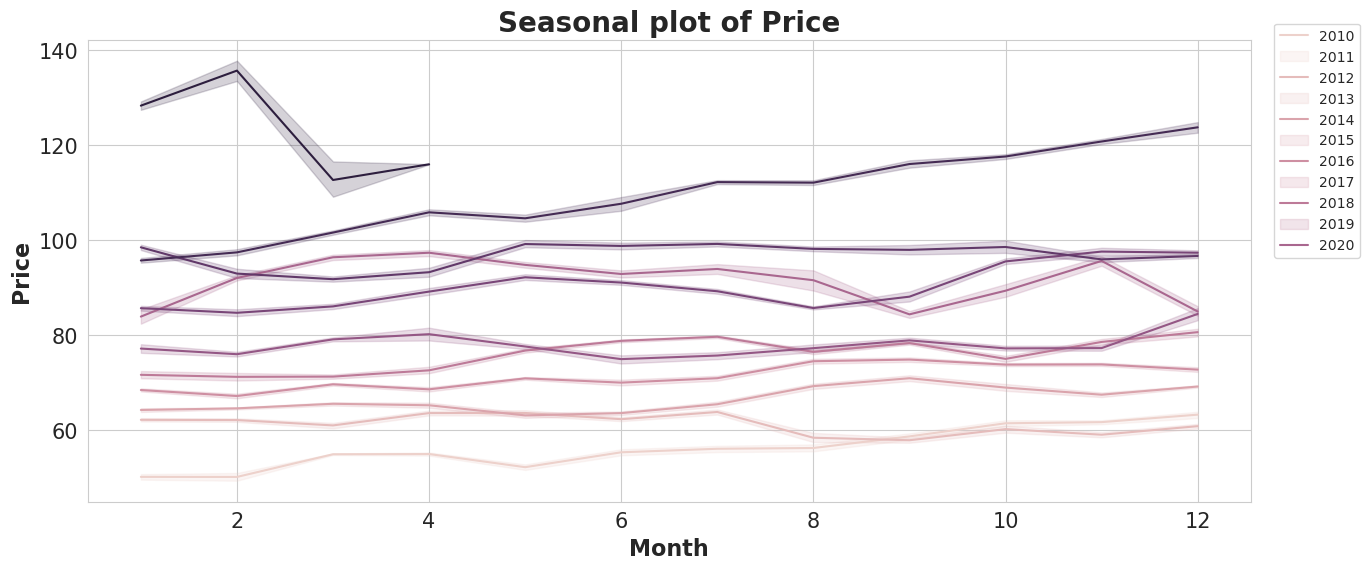

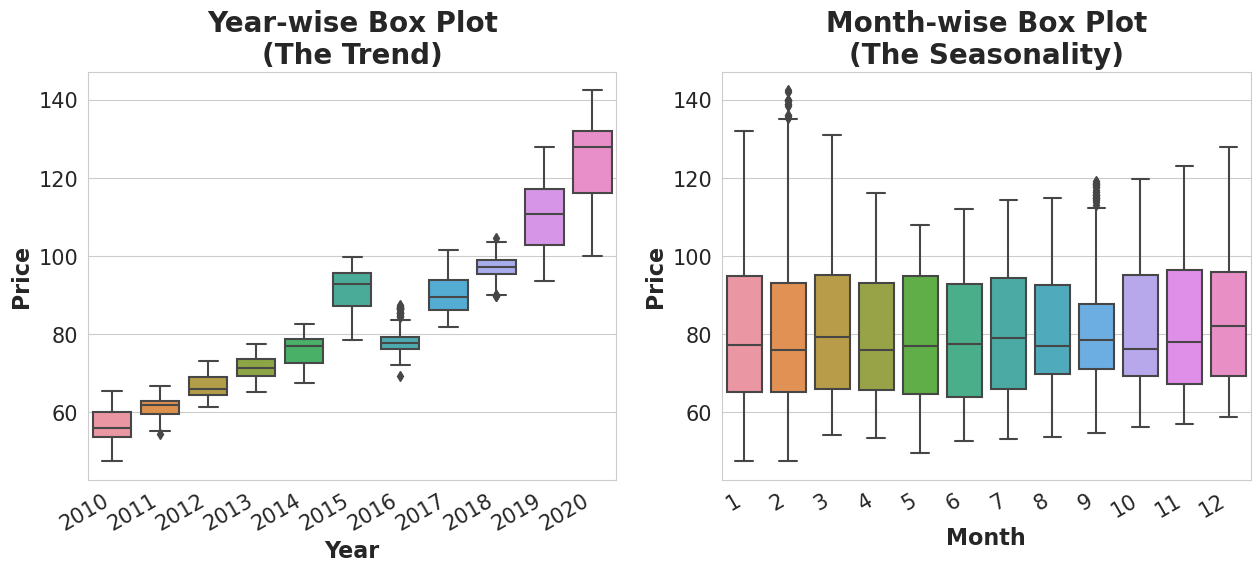

In [35]:
# Set the variable to plot
variable = 'Open'

# Create a figure with one plot
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the seasonal line plot
sns.lineplot(x = imputed_air_liquide['Month'], y = imputed_air_liquide[variable], hue = imputed_air_liquide['Year'])

# Format the plot
ax.set_title('Seasonal plot of Price', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
ax.legend(labels = [str(2010+i) for i in range(11)], bbox_to_anchor=(1.1, 1.05))

# Create a figure with two plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot the year-wise box plot
sns.boxplot(x = imputed_air_liquide['Year'], y = imputed_air_liquide[variable], ax=ax[0])

# Format the year-wise box plot
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))

# Plot the month-wise box plot
sns.boxplot(x = imputed_air_liquide['Month'], y = imputed_air_liquide[variable], ax=ax[1])

# Format the month-wise box plot
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))

# Rotate the x-axis labels for better readability
fig.autofmt_xdate()

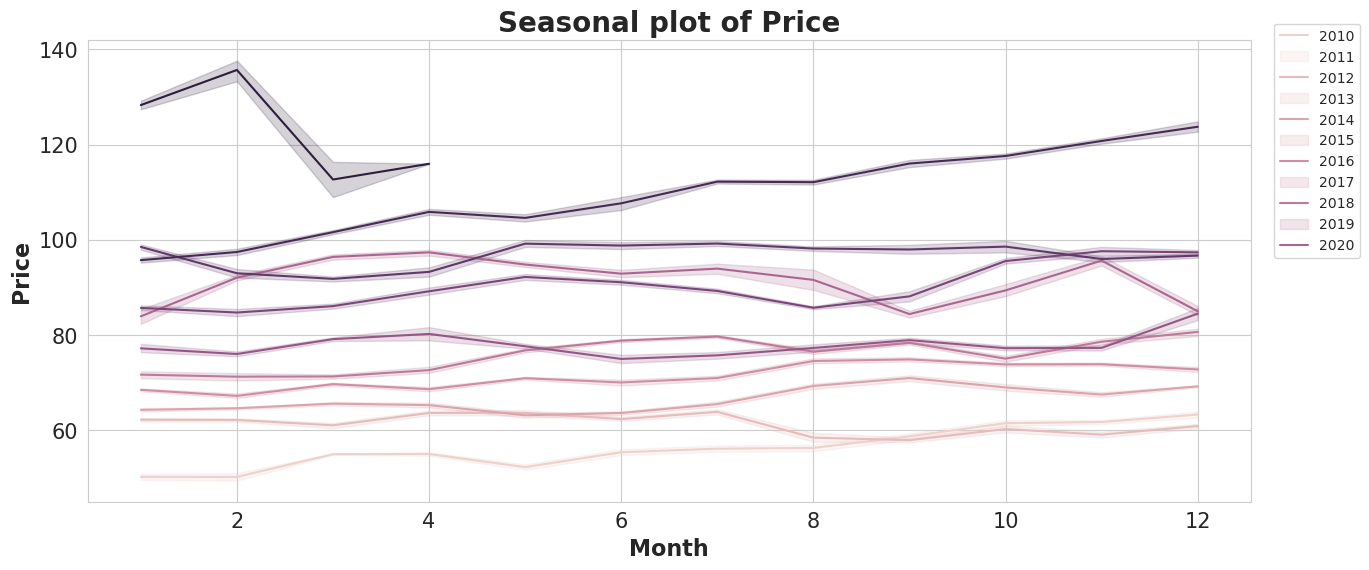

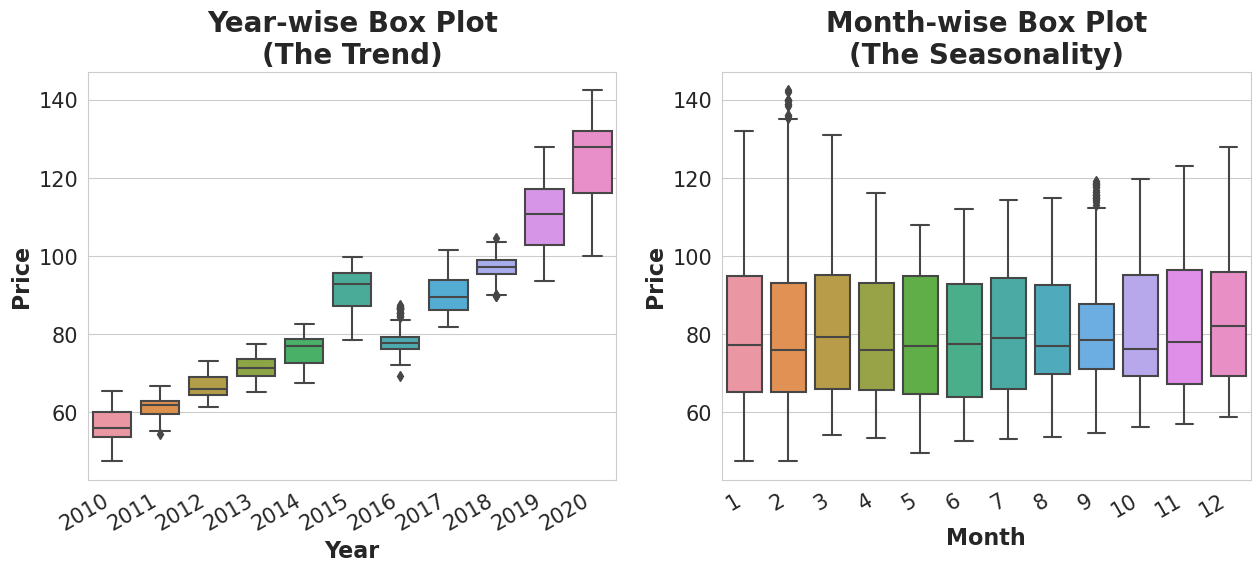

In [36]:
variable = 'Open'

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = imputed_air_liquide['Month'], y = imputed_air_liquide[variable], hue = imputed_air_liquide['Year'])
ax.set_title('Seasonal plot of Price', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
ax.legend(labels = [str(2010+i) for i in range(11)], bbox_to_anchor=(1.1, 1.05))


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.boxplot(x = imputed_air_liquide['Year'], y = imputed_air_liquide[variable], ax=ax[0])
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))


sns.boxplot(x = imputed_air_liquide['Month'], y = imputed_air_liquide[variable], ax=ax[1])
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))

fig.autofmt_xdate()

Text(0, 0.5, 'Closing_Price')

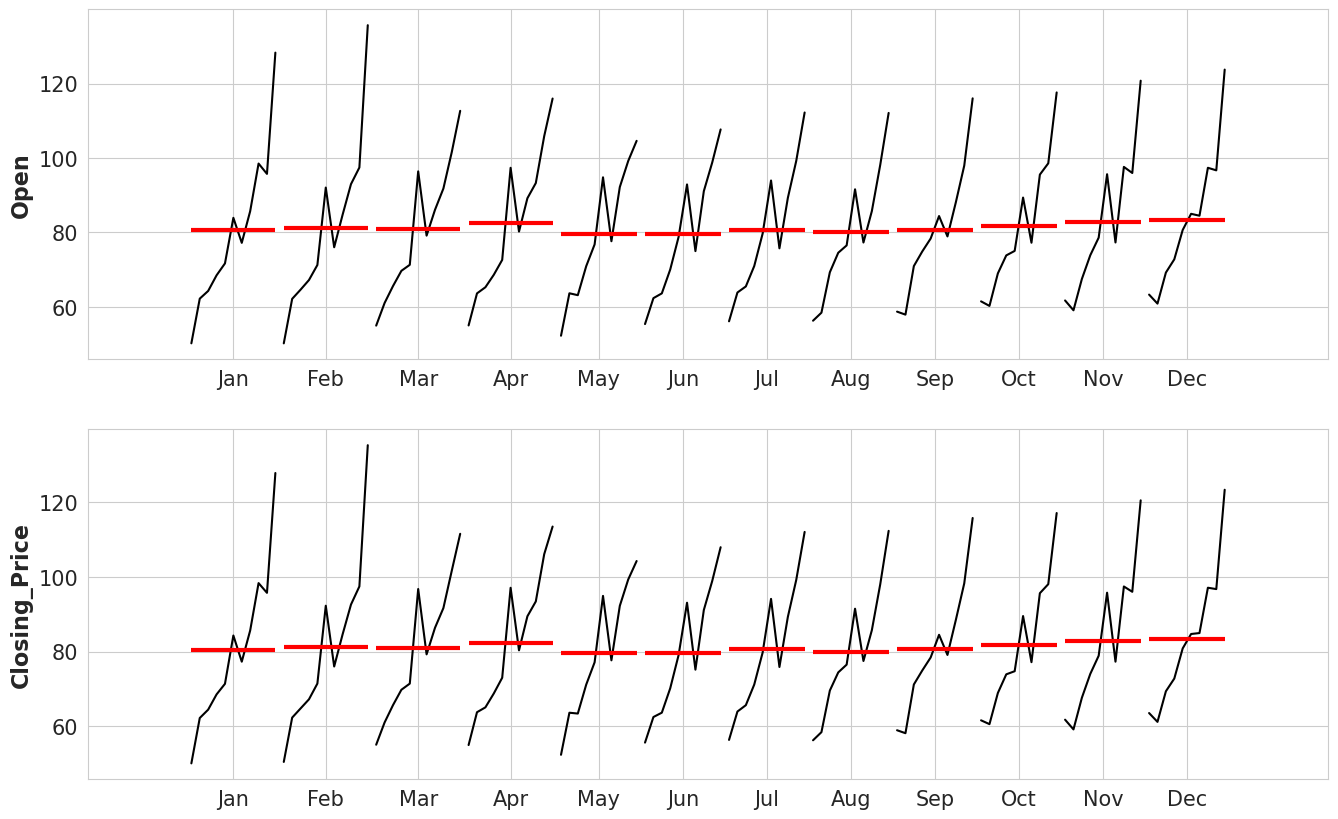

In [37]:
y = imputed_air_liquide[['Date','Open','Closing_Price']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# Create the seasonal subseries plots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

month_plot(y['Open'], ax=ax[0]);
ax[0].set_ylabel('Open', fontsize = 16, fontdict=dict(weight='bold'))

month_plot(y['Closing_Price'], ax=ax[1]);
ax[1].set_ylabel('Closing_Price', fontsize = 16, fontdict=dict(weight='bold'))

Text(0.5, 0.98, 'Open decomposition')

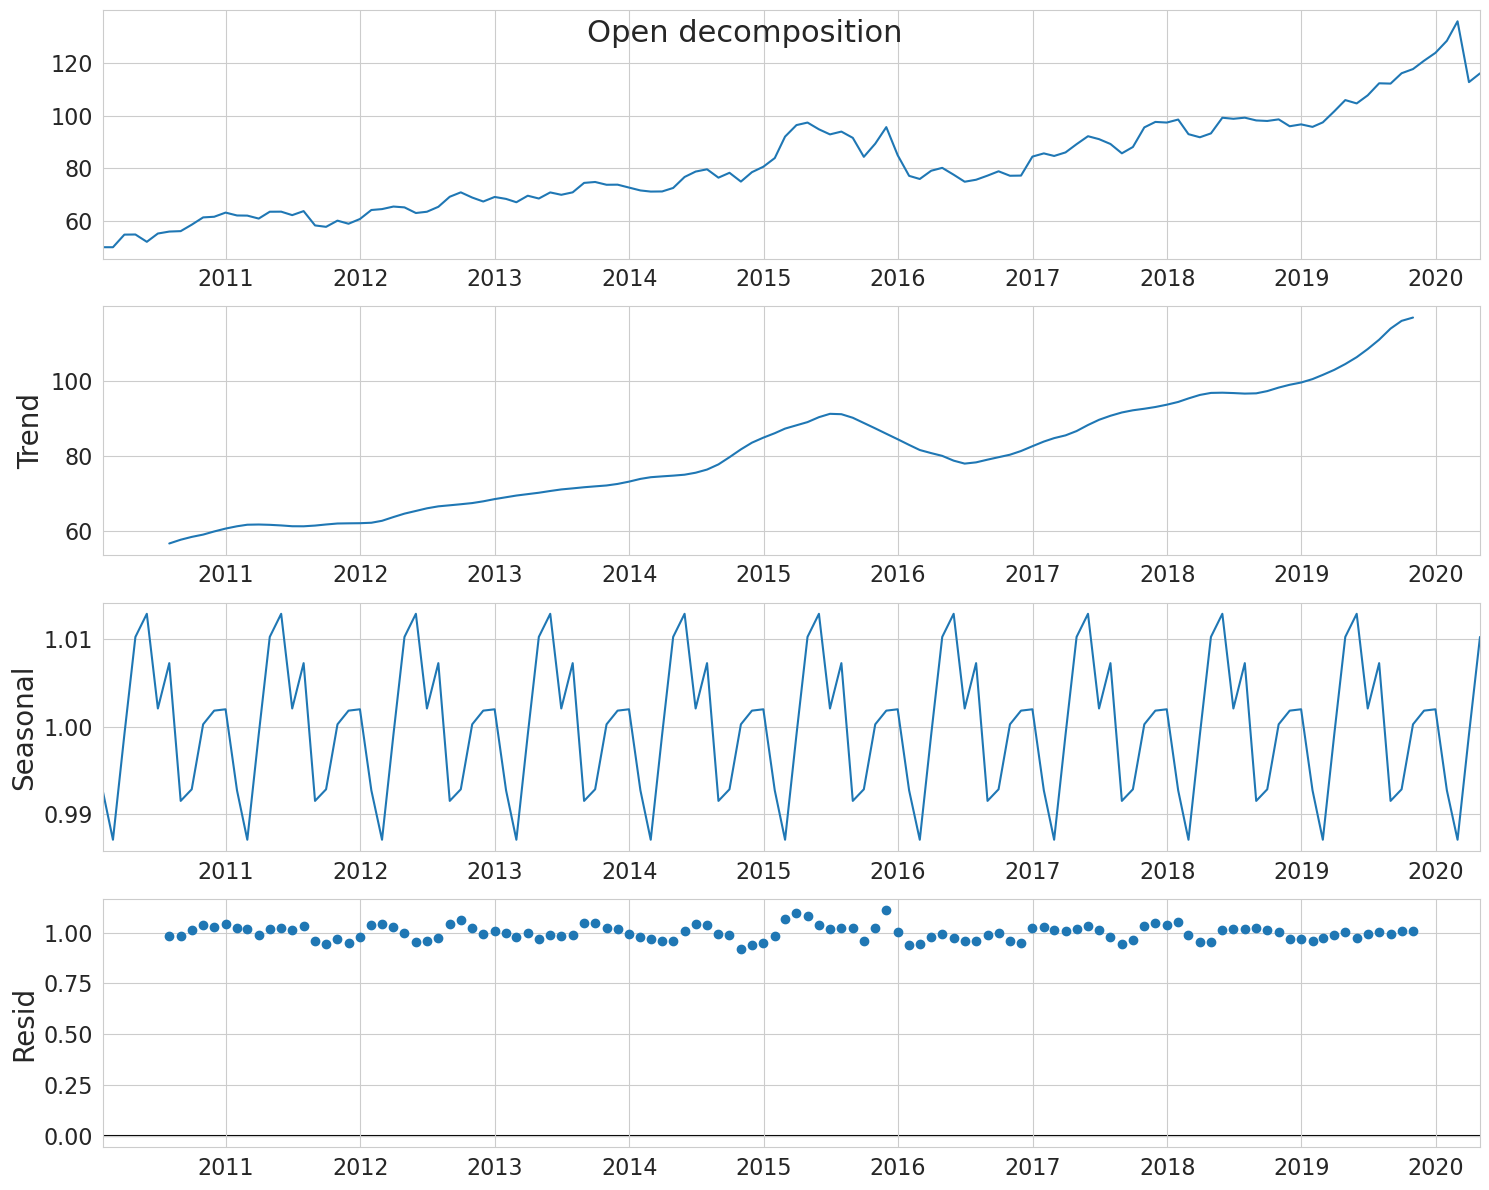

In [38]:
# Aggregating the Time Series to a monthly scaled index
y = imputed_air_liquide[['Date', 'Open']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# Setting rcparams for plot size and font size
rcParams['figure.figsize'] = 15, 12
rcParams['axes.labelsize'] = 20
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16

# Using statistical tools of statsmodel library to perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')

# Plotting the decomposition
decomp = decomposition.plot()
decomp.suptitle('Open decomposition', fontsize=22)

### Augmented Dickey-Fuller test
**In statistics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. It is an augmented version of the Dickey–Fuller test for a larger and more complicated set of time series models.**

![img](https://slideplayer.com/slide/13461888/80/images/70/ADF+TEST+Hence%2C+testing+for+a+unit+root+is+equivalent+to+testing+%EF%81%A6%3D1+in+the+following+model+or.jpg)

In [39]:
def adf_test(series, title=''): 
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    
    # Perform Augmented Dickey-Fuller test
    result = adfuller(series.dropna(),autolag='AIC') 
    
    # Create a Series object with the test statistics and critical values
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    
    # Add the critical values to the Series object
    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    # Print the ADF report
    print(out.to_string())          
    
    # Check for stationarity based on the p-value
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [40]:
# Aggregating the Time Series a monthly scaled index.
y = imputed_air_liquide[["Date", "Open"]].copy()
y.set_index("Date", inplace = True)
y.index = pd.to_datetime(y.index)
y = y.resample("1M").mean()

adf_test(y["Open"], title = "")

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.196686
p-value                   0.938915
# lags used               2.000000
# observations          121.000000
critical value (1%)      -3.485585
critical value (5%)      -2.885739
critical value (10%)     -2.579676
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


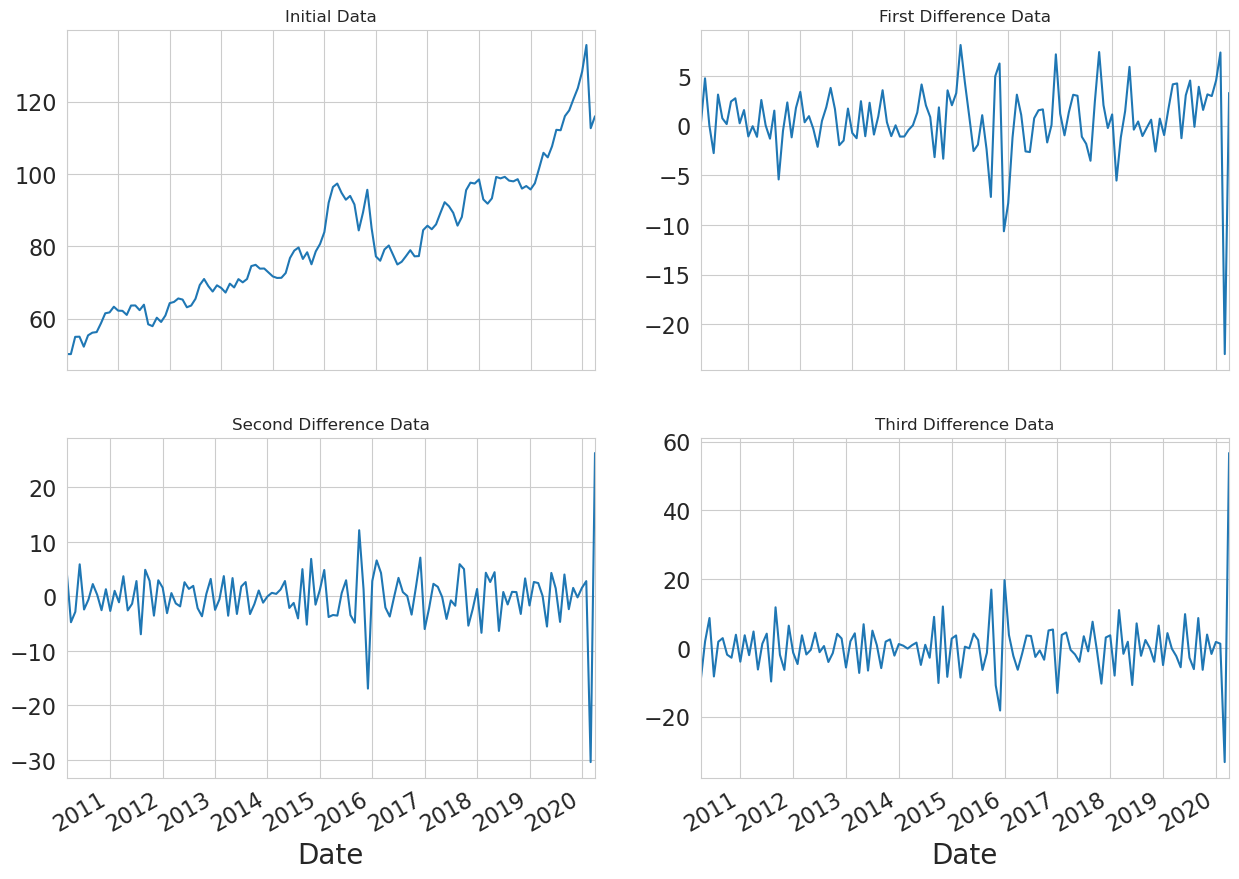

In [41]:
# Create a 2x2 grid of subplots
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

# Apply differencing to the 'Open' column and add it to the dataframe
y['OpenDiff1'] = diff(y['Open'], k_diff=1)
y['OpenDiff2'] = diff(y['Open'], k_diff=2)
y['OpenDiff3'] = diff(y['Open'], k_diff=3)

# Plot the initial 'Open' data on the first subplot
y['Open'].plot(title="Initial Data", ax=ax[0][0]).autoscale(axis='x', tight=True);

# Plot the first difference data on the second subplot
y['OpenDiff1'].plot(title="First Difference Data", ax=ax[0][1]).autoscale(axis='x', tight=True);

# Plot the second difference data on the third subplot
y['OpenDiff2'].plot(title="Second Difference Data", ax=ax[1][0]).autoscale(axis='x', tight=True);

# Plot the third difference data on the fourth subplot
y['OpenDiff3'].plot(title="Third Difference Data", ax=ax[1][1]).autoscale(axis='x', tight=True);

# Rotate the x-axis labels to make them easier to read
fig.autofmt_xdate()

[1.         0.99669167 0.99397744 0.99114807 0.98842329 0.98574882
 0.98327505 0.98065432 0.97792933 0.97569862 0.97316217 0.97091567
 0.96872365 0.96677005 0.96448024 0.96224729 0.95968184 0.95699272
 0.95423987 0.95126885 0.94815404 0.94479836 0.94160485 0.93854499
 0.93560843 0.93284805 0.92976929 0.92688093 0.92378304 0.92046489
 0.91730545 0.91394706 0.91064856 0.90743726 0.90426107 0.90102265
 0.89772752 0.89464738 0.89163062 0.88862379 0.88584496 0.88294789
 0.88021878 0.87768629 0.87519469 0.87266679 0.87039248 0.86809038
 0.86572663 0.86328034 0.86084315 0.85844897 0.85612914 0.85390287
 0.85154451 0.84929882 0.84707093 0.84483261 0.84257198 0.84030894
 0.83812315]


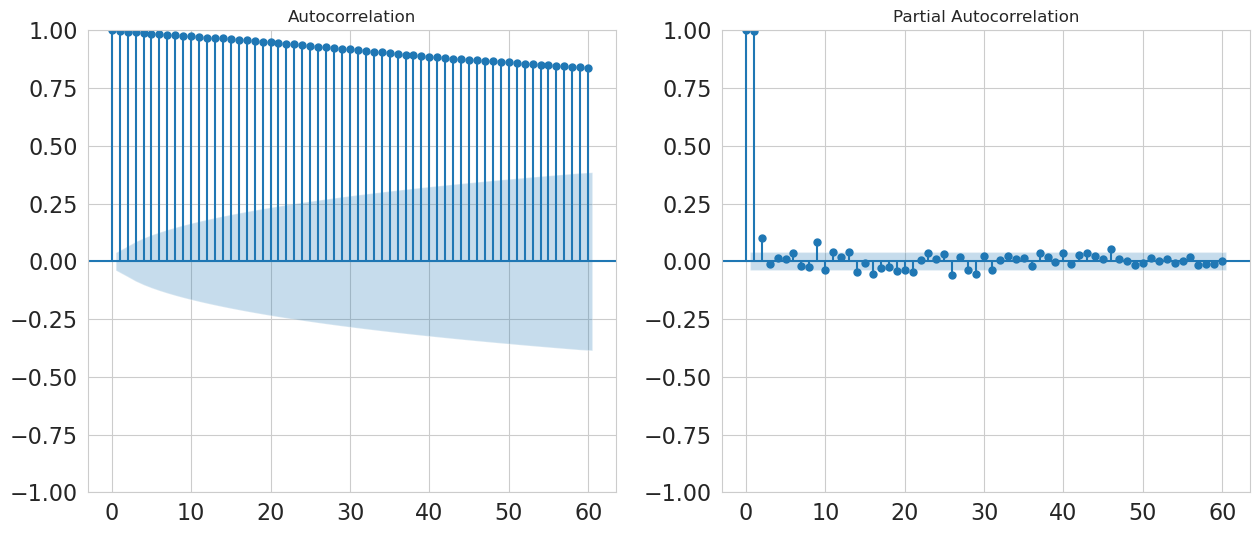

In [42]:
# Creating a figure with two subplots
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15, 6))

# Calculating autocorrelation function (ACF) with 60 lags for Open prices
autocorr = acf(imputed_air_liquide['Open'], nlags=60, fft=False)
print(autocorr)

# Plotting the ACF with 60 lags on the first subplot
plot_acf(imputed_air_liquide['Open'].tolist(), lags=60, ax=ax[0], fft=False);

# Plotting the partial autocorrelation function (PACF) with 60 lags on the second subplot
plot_pacf(imputed_air_liquide['Open'].tolist(), lags=60, ax=ax[1]);

[1.         0.99669167 0.99397744 0.99114807 0.98842329 0.98574882
 0.98327505 0.98065432 0.97792933 0.97569862 0.97316217 0.97091567
 0.96872365 0.96677005 0.96448024 0.96224729 0.95968184 0.95699272
 0.95423987 0.95126885 0.94815404 0.94479836 0.94160485 0.93854499
 0.93560843 0.93284805 0.92976929 0.92688093 0.92378304 0.92046489
 0.91730545 0.91394706 0.91064856 0.90743726 0.90426107 0.90102265
 0.89772752 0.89464738 0.89163062 0.88862379 0.88584496 0.88294789
 0.88021878 0.87768629 0.87519469 0.87266679 0.87039248 0.86809038
 0.86572663 0.86328034 0.86084315 0.85844897 0.85612914 0.85390287
 0.85154451 0.84929882 0.84707093 0.84483261 0.84257198 0.84030894
 0.83812315]


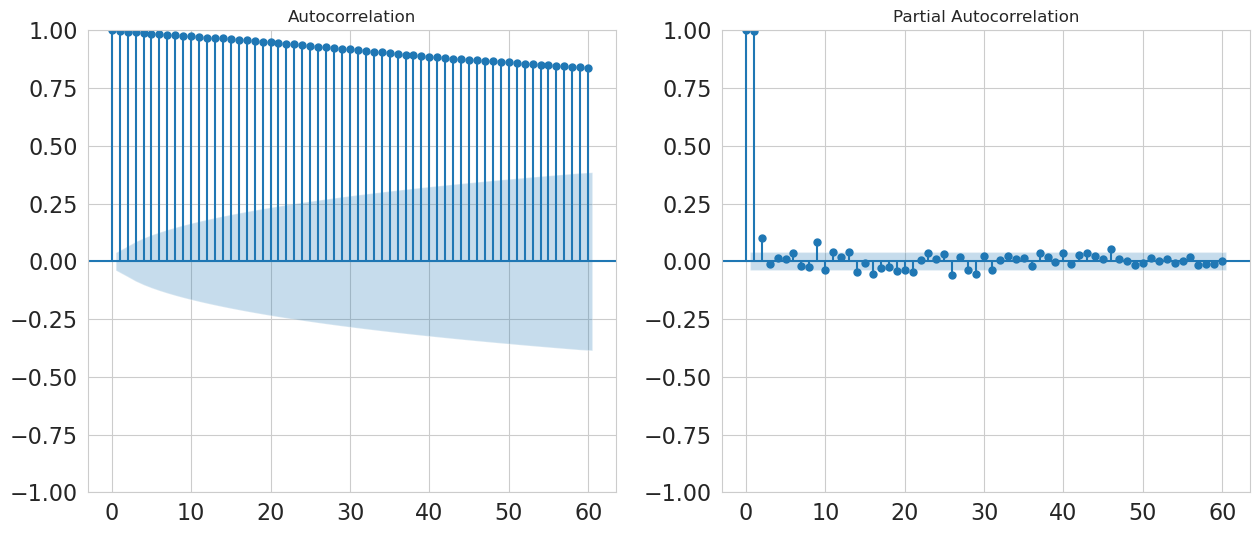

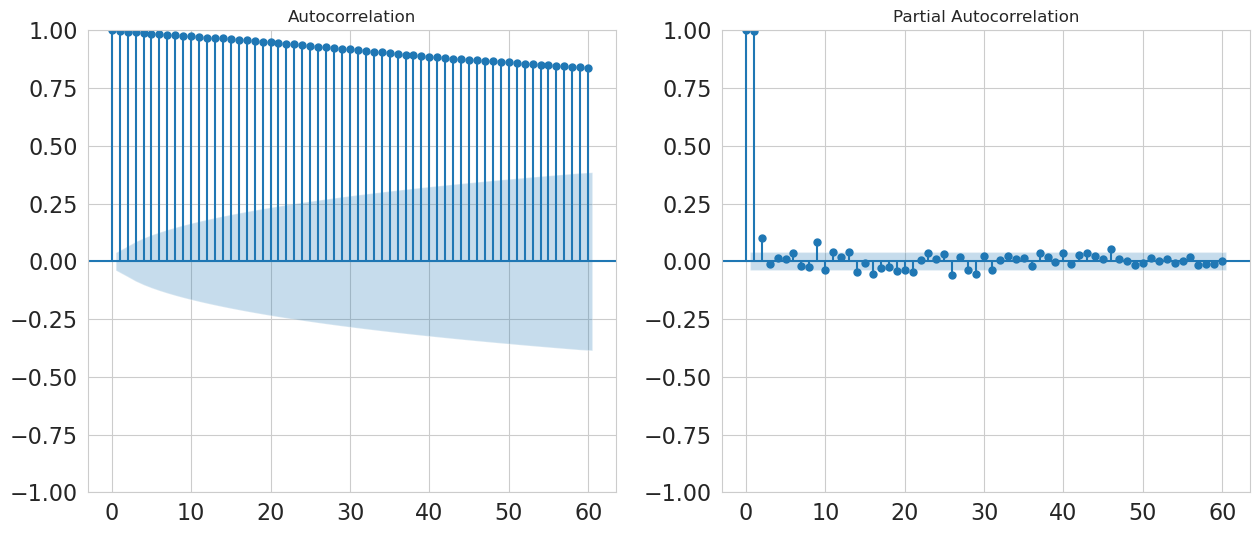

In [43]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))

autocorr = acf(imputed_air_liquide["Open"], nlags = 60, fft = False)
print(autocorr)

plot_acf(imputed_air_liquide["Open"].tolist(), lags = 60, ax = ax[0], fft = False);

plot_pacf(imputed_air_liquide["Open"].tolist(), lags = 60, ax = ax[1])

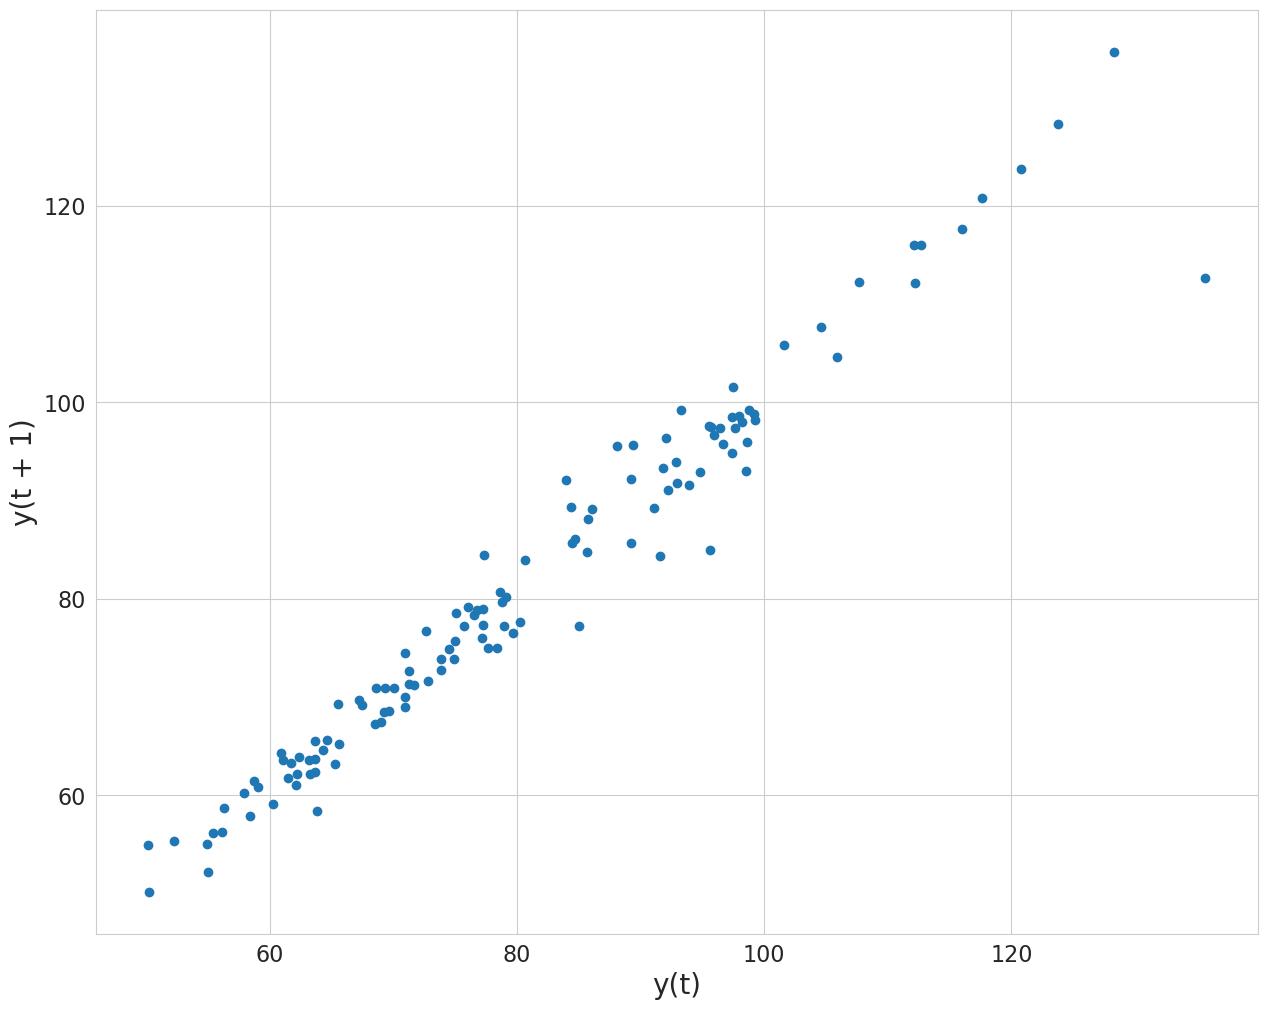

In [44]:
lag_plot(y['Open']);

<Axes: xlabel='Date'>

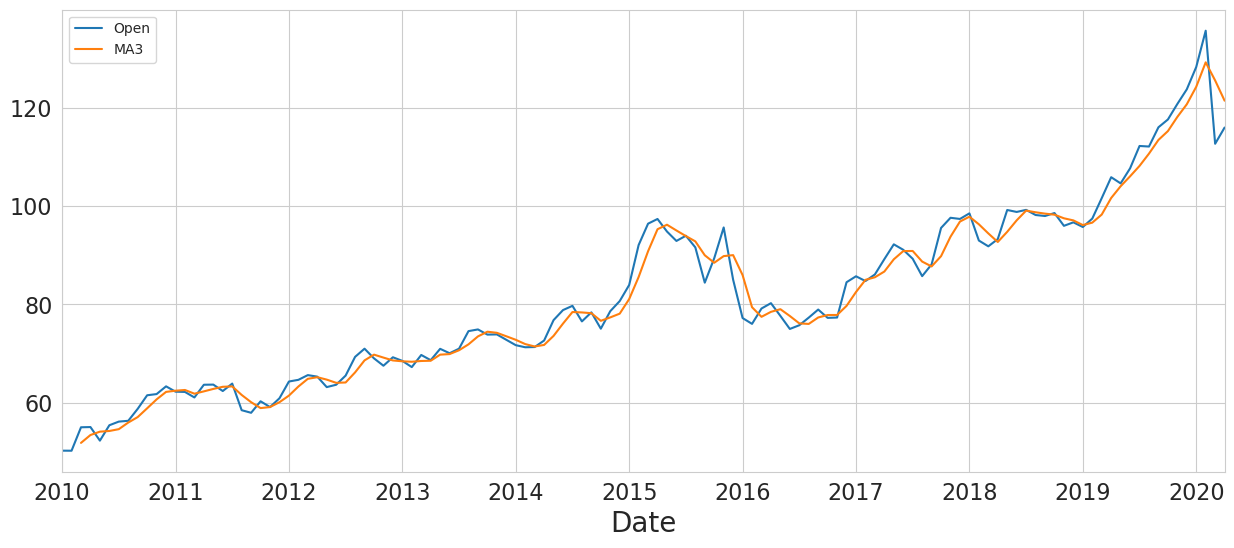

In [45]:
y = imputed_air_liquide[["Date", "Open"]].copy()
y.set_index("Date", inplace = True)
y.index = pd.to_datetime(y.index)
y = y.resample("1M").mean()

y["MA3"] = y.rolling(window = 3).mean()

y.plot(figsize = (15, 6))

<Axes: xlabel='Date'>

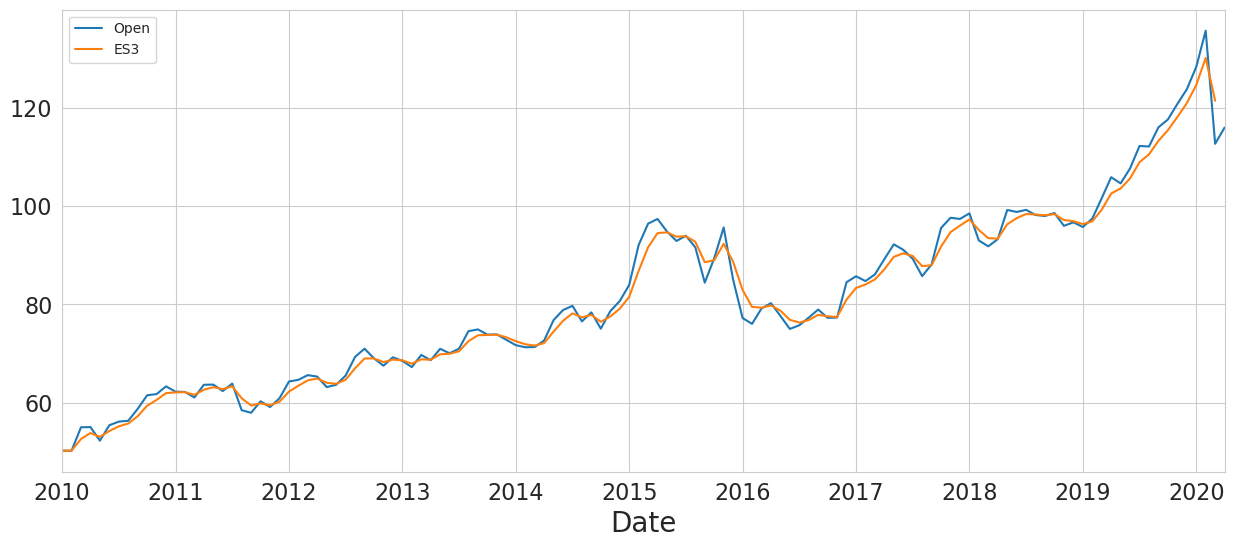

In [46]:
span = 3
alpha = 2 / (span + 1)

y["ES3"] = SimpleExpSmoothing(y["Open"]).fit(smoothing_level = alpha, optimized = False).fittedvalues.shift(-1)

y[["Open", "ES3"]].plot(figsize = (15, 6))

<Axes: xlabel='Date'>

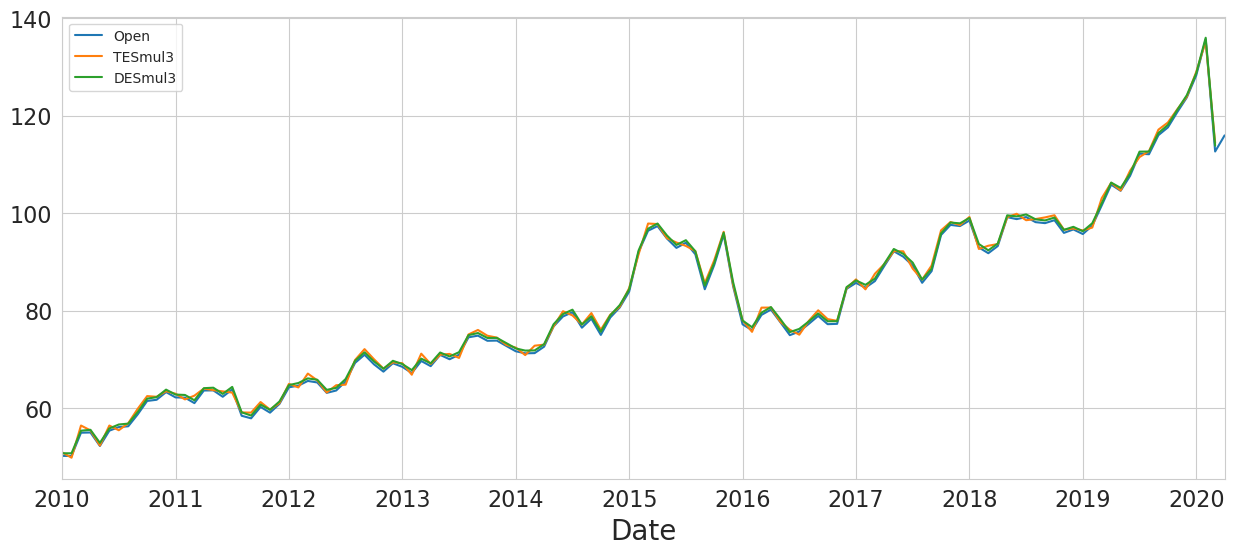

In [47]:
# Plot Double and Triple exponential smoothing

# Double Exponential Smoothing (Holt's Linear Method)
y['DESmul3'] = ExponentialSmoothing(y['Open'], trend='add').fit().fittedvalues.shift(-1)

# Triple Exponential Smoothing (Holt-Winters' Method)
y['TESmul3'] = ExponentialSmoothing(y['Open'], trend='add', seasonal='add', seasonal_periods=12).fit().fittedvalues.shift(-1)

# Plot the original time series and the two smoothed versions
y[['Open', 'TESmul3', 'DESmul3']].plot(figsize=(15, 6))

In [48]:
# Reverse index so the dataframe is from oldest to newest values
imputed_air_liquide = imputed_air_liquide.reindex(index=imputed_air_liquide.index[::-1])

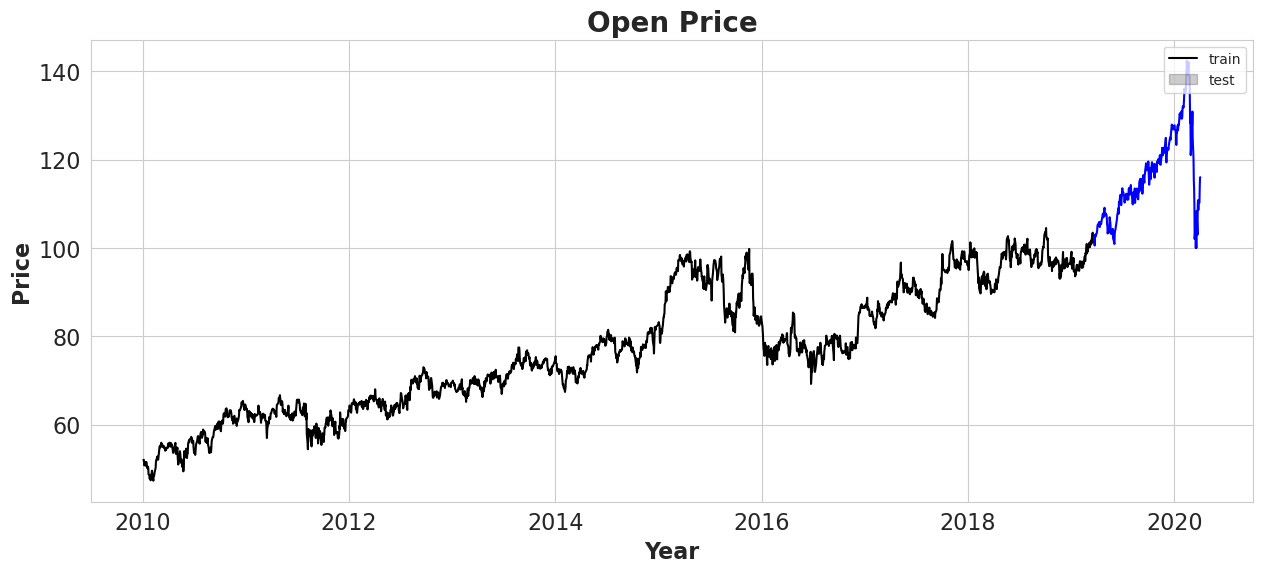

In [49]:
air_liquide_train, air_liquide_val = imputed_air_liquide[:int(len(imputed_air_liquide) * 0.9)], imputed_air_liquide[int(len(imputed_air_liquide) * 0.9):]

air_liquide_val = air_liquide_val.set_index("Date", drop = False)
air_liquide_train = air_liquide_train.set_index("Date", drop = False)

fig, ax = plt.subplots(figsize = (15, 6))
sns.lineplot(x = air_liquide_train["Date"], y = air_liquide_train["Open"], color = "black")
sns.lineplot(x = air_liquide_val["Date"], y = air_liquide_val["Open"], color = "blue")

ax.set_title("Open Price", fontsize = 20, loc = "center", fontdict = dict(weight = "bold"))
ax.set_xlabel("Year", fontsize = 16, fontdict = dict(weight = "bold"))
ax.set_ylabel("Price", fontsize = 16, fontdict = dict(weight = "bold"))
plt.tick_params(axis = "y", which = "major", labelsize = 16)
plt.tick_params(axis = "x", which = "major", labelsize = 16)
plt.legend(loc = "upper right", labels = ("train", "test"))

In [50]:
%%time
model_autoARIMA = auto_arima(air_liquide_train['Open'])

""", 
                             start_p = 0, 
                             start_q = 0,
                             test = 'adf', # use adftest to find optimal 'd'
                             max_p = 3,
                             max_q = 3, # maximum p and q
                             m = 7, # frequency of series
                             seasonal = False,
                             start_P = 0, 
                             D = 0, 
                             trace = True,
                             error_action = 'ignore',  
                             stepwise = True
"""

print(model_autoARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2340
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -3405.792
Date:                Mon, 19 Jun 2023   AIC                           6821.584
Time:                        03:09:01   BIC                           6850.371
Sample:                             0   HQIC                          6832.071
                               - 2340                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.000      1.726      0.084   -9.87e-05       0.002
ar.L1          0.8530      0.019     45.915      0.000       0.817       0.889
ar.L2          0.1119      0.017      6.677      0.0

In [51]:
model = ARIMA(air_liquide_train['Open'], order = (1, 1, 2))
# disp=-1: no output

fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                 2340
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -3407.252
Date:                Mon, 19 Jun 2023   AIC                           6822.504
Time:                        03:09:02   BIC                           6845.534
Sample:                             0   HQIC                          6830.894
                               - 2340                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9603      0.023     42.655      0.000       0.916       1.004
ma.L1         -1.0936      0.028    -38.420      0.000      -1.149      -1.038
ma.L2          0.1154      0.018      6.405      0.0

In [52]:
# Forecast 260 next observations 
fc = fitted.forecast(260, alpha=0.05) # 95% confidence
conf = fitted.forecast(260, alpha = 0.05)
se = fitted.forecast(260, alpha=0.05)
fc_series = pd.Series(fc, index=air_liquide_val.index)
lower_series = pd.Series(conf[:, 0], index=air_liquide_val.index)
upper_series = pd.Series(conf[:, 1], index=air_liquide_val.index)

# Plotting the predicted and actual stock prices
plt.figure(figsize=(12,5), dpi=100)
plt.plot(air_liquide_train['Open'], label='training')
plt.plot(air_liquide_val['Open'], color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Air Liquide Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

KeyError: 'key of type tuple not found and not a MultiIndex'

In [53]:
# Report performances
mse = mean_squared_error(air_liquide_val['Open'], fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(air_liquide_val['Open'], fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(air_liquide_val['Open'], fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - air_liquide_val['Open'])/np.abs(air_liquide_val['Open']))
print('MAPE: '+str(mape))

MSE: 323.94442806596925
MAE: 15.13425741005199
RMSE: 17.998456268968436
MAPE: nan
